In [12]:
import matplotlib.pyplot as plt

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
import jax
from jax import jit

from datetime import date

rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))
from functools import partial
from warnings import filterwarnings

from flax import linen as nn
from flax.linen.initializers import ones
import jax.numpy as jnp
import numpy as np
import tensorflow_probability.substrates.jax.distributions as tfd

from sklearn.datasets import make_moons
from sklearn.preprocessing import scale

import blackjax
import optax
from jax.flatten_util import ravel_pytree
#from blackjax.vi.svgd import update_median_heuristic

import svgd_function


filterwarnings("ignore")
import matplotlib as mpl

cmap = mpl.colormaps["coolwarm"]

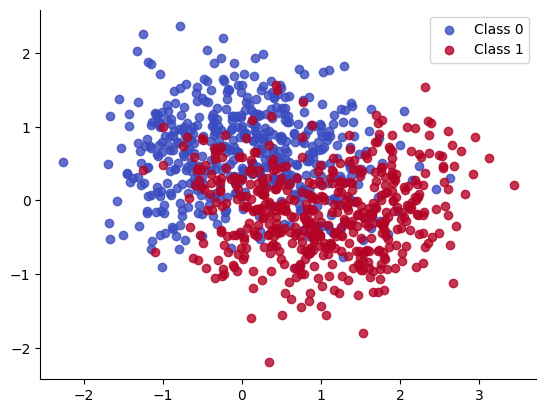

In [13]:
n_samples = 1000
grid = jnp.mgrid[-3:3:100j, -3:3:100j].reshape((2, -1)).T

Xs, Ys = make_moons(noise=0.5, n_samples=n_samples)
for i in range(2):
    plt.scatter(Xs[Ys == i, 0], Xs[Ys == i, 1], color=cmap(float(i)), label=f"Class {i}", alpha=.8)
plt.legend();

In [14]:
Xs_train = Xs[: n_samples // 2 ,:]
Xs_test = Xs[n_samples // 2 :,:]
Ys_train = Ys[: n_samples // 2]
Ys_test = Ys[n_samples // 2 :]

In [15]:
@jit
def rbf_kernel(x, y, length_scale=1):
    arg = ravel_pytree(jax.tree_util.tree_map(lambda x, y: (x - y) ** 2, x, y))[0]
    return jnp.exp(-(1 / length_scale) * arg.sum())

@jit
def median_heuristic(kernel_parameters, particles):
    particle_array = jax.vmap(lambda p: ravel_pytree(p)[0])(particles)

    def distance(x, y):
        return jnp.linalg.norm(jnp.atleast_1d(x - y))

    vmapped_distance = jax.vmap(jax.vmap(distance, (None, 0)), (0, None))
    A = vmapped_distance(particle_array, particle_array)  # Calculate distance matrix
    pairwise_distances = A[
        jnp.tril_indices(A.shape[0], k=-1)
    ]  # Take values below the main diagonal into a vector
    median = jnp.median(pairwise_distances)
    kernel_parameters["length_scale"] = (median**2) / jnp.log(particle_array.shape[0])
    return kernel_parameters

In [16]:
def inference_loop(rng_key, step_fn, initial_state, num_samples, num_particles):
    def one_step(state, selected_indices):
        state = step_fn(state, [1, 3, 5, 7], np.setdiff1d(np.arange(num_particles), np.array([1, 3, 5, 7])))
        return state, state

    keys = jax.random.split(rng_key, num_samples) #keys erweitern, testen (oder for loop benutzen)
    print(type(keys))
    _, states  = jax.lax.scan(one_step, initial_state, keys)

    return states

In [17]:
def get_predictions(model, samples, X, rng_key):
    vectorized_apply = jax.vmap(model.apply, in_axes=(0, None), out_axes=0)
    z = vectorized_apply(samples, X)
    predictions = tfd.Bernoulli(logits=z).sample(seed=rng_key)

    return predictions.squeeze(-1)

In [18]:
def get_mean_predictions(predictions, threshold=0.5):
    # compute mean prediction and confidence interval around median
    mean_prediction = jnp.mean(predictions, axis=0)
    return mean_prediction > threshold

In [19]:
def fit_and_eval(
    rng_key,
    model,
    logdensity_fn,
    X_train,
    Y_train,
    X_test,
    grid,
    num_samples=400
):
    (
        init_key,
        inference_key,
        train_key,
        test_key,
        grid_key,
    ) = jax.random.split(rng_key, 5)

    initial_position = model.init(init_key, jnp.ones(X_train.shape[-1]))
    _, unravel_fct = ravel_pytree(initial_position)

    # initialization
    logprob = partial(logdensity_fn, X=X_train, Y=Y_train, model=model, unravel_function = unravel_fct)

    num_particles = 200
    num_bnn_parameters = sum(p.size for p in jax.tree_util.tree_flatten(initial_position)[0])
    initial_particles = jax.random.normal(jax.random.PRNGKey(3),shape=(num_particles,num_bnn_parameters))

    #optax.adam(0.3
    svgd = svgd_function.svgd(jax.grad(logprob), optax.sgd(0.3), rbf_kernel, svgd_function.update_median_heuristic)
    state = svgd.init(initial_particles, median_heuristic({"length_scale": 1}, initial_particles))

    particles_raw, kernel_params, opt_state = state

    selected_indices = jnp.array([1, 3, 5, 7])
    print(opt_state)

    #opt = opt_state[0][1].at[selected_indices].set(selected_particles)
    
    step_fn = jax.jit(svgd.step)
    states = inference_loop(inference_key, step_fn, state, num_samples, num_particles)

    particle_dicts = states.particles[num_samples]
    samples = jnp.apply_along_axis(unravel_fct, arr=particle_dicts, axis=1)

    predictions = get_predictions(model, samples, X_train, train_key)
    Y_pred_train = get_mean_predictions(predictions)
    predictions = get_predictions(model, samples, X_test, test_key)
    Y_pred_test = get_mean_predictions(predictions)
    pred_grid = get_predictions(model, samples, grid, grid_key)

    return Y_pred_train, Y_pred_test, pred_grid

# MLP

In [20]:
# MLP params
hidden_layer_width = 5
n_hidden_layers = 2

class NN(nn.Module):
    n_hidden_layers: int
    layer_width: int

    @nn.compact
    def __call__(self, x):
        for i in range(self.n_hidden_layers):
            x = nn.Dense(features=self.layer_width)(x)
            x = nn.tanh(x)
        return nn.Dense(features=1)(x)


bnn = NN(n_hidden_layers, hidden_layer_width)

In [21]:
def logprior_fn(params):
    leaves, _ = jax.tree_util.tree_flatten(params)
    flat_params = jnp.concatenate([jnp.ravel(a) for a in leaves])
    return jnp.sum(tfd.Normal(0, 1).log_prob(flat_params))


def loglikelihood_fn(params, X, Y, model, unravel_function):
    params_dict = unravel_function(params)
    logits = jnp.ravel(model.apply(params_dict, X))
    return jnp.sum(tfd.Bernoulli(logits).log_prob(Y))


def logdensity_fn_of_bnn(params, X, Y, model, unravel_function):
    return logprior_fn(params) + loglikelihood_fn(params, X, Y, model, unravel_function)

In [22]:
rng_key, eval_key = jax.random.split(rng_key)


def fit_and_eval_single_mlp(key, X_train, Y_train, X_test):
    return fit_and_eval(
        key, bnn, logdensity_fn_of_bnn, X_train, Y_train, X_test, grid
    )


Ys_pred_train, Ys_pred_test, ppc_grid_single = fit_and_eval_single_mlp(eval_key, Xs_train, Ys_train, Xs_test)

(EmptyState(), EmptyState())
<class 'jax._src.prng.PRNGKeyArrayImpl'>


In [23]:
print(f"Train accuracy = {100 * jnp.mean(Ys_pred_train == Ys_train):.2f}%")

Train accuracy = 60.00%


In [24]:
print(f"Test accuracy = {100 * jnp.mean(Ys_pred_test == Ys_test):.2f}%")

Test accuracy = 56.20%


Train-Data:


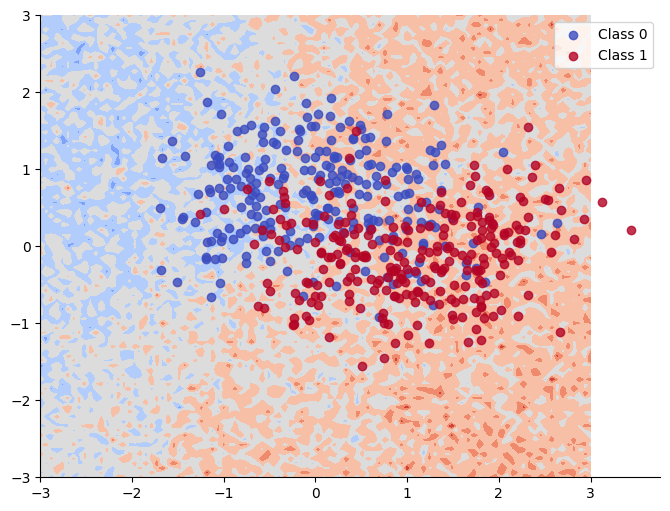

In [25]:
def plot_decision_surfaces_non_hierarchical(train = True):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.contourf(
        grid[:, 0].reshape(100, 100),
        grid[:, 1].reshape(100, 100),
        ppc_grid_single[...].mean(axis=0).reshape(100, 100),
        cmap=cmap,
    )
    if train == True:
        print("Train-Data:")
        for i in range(2):
            ax.scatter(
                Xs_train[Ys_train == i, 0], Xs_train[Ys_train == i, 1], 
                color=cmap(float(i)), label=f"Class {i}", alpha=.8)
    else:
        print("Test-Data:")
        for i in range(2):
            ax.scatter(
                Xs_test[Ys_test == i, 0], Xs_test[Ys_test == i, 1], 
                color=cmap(float(i)), label=f"Class {i}", alpha=.8)
    ax.legend()

plot_decision_surfaces_non_hierarchical()

Test-Data:


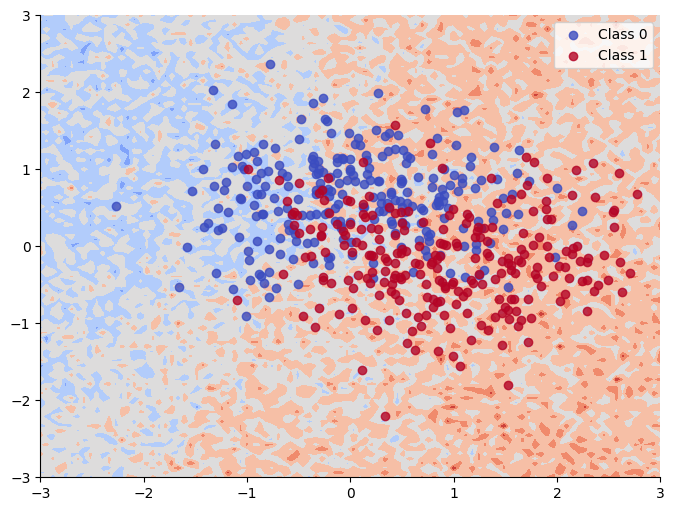

In [26]:
plot_decision_surfaces_non_hierarchical(train=False)